# "X-RayNet: ResNet-Based Classifier for COVID-19 and Pneumonia Detection"

# Import libraries

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

# Load dataset

In [2]:
# Paths
original_data_dir = r"C:\Users\apeks\Downloads\archive (3)"
base_dir = r"C:\Users\apeks\Downloads\Generated_data"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')


# Split into train, test and val 

In [7]:
# Split the dataset into train, val, test folders
def prepare_dataset():
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)

    os.makedirs(train_dir)
    os.makedirs(val_dir)
    os.makedirs(test_dir)

    classes = ['COVID', 'NORMAL', 'PNEUMONIA']
    for cls in classes:
        imgs = os.listdir(os.path.join(original_data_dir, cls))
        train_imgs, testval_imgs = train_test_split(imgs, test_size=0.4, random_state=42)
        val_imgs, test_imgs = train_test_split(testval_imgs, test_size=0.5, random_state=42)

        for split, split_imgs in zip([train_dir, val_dir, test_dir], [train_imgs, val_imgs, test_imgs]):
            cls_path = os.path.join(split, cls)
            os.makedirs(cls_path)
            for img in split_imgs:
                src = os.path.join(original_data_dir, cls, img)
                dst = os.path.join(cls_path, img)
                shutil.copy(src, dst)

prepare_dataset()


# Class counts

In [8]:
# Define the path to the dataset splits
splits = ['train', 'val', 'test']
class_counts = {}

# Count images in each class across all splits
for split in splits:
    split_path = os.path.join(base_dir, split)
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        count = len(os.listdir(cls_path))
        class_counts[cls] = class_counts.get(cls, 0) + count

# Sort the dictionary by class name for consistent plotting
class_counts = dict(sorted(class_counts.items()))


# Barchart

C:\Users\apeks\AppData\Local\Temp\ipykernel_22204\1895362288.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')


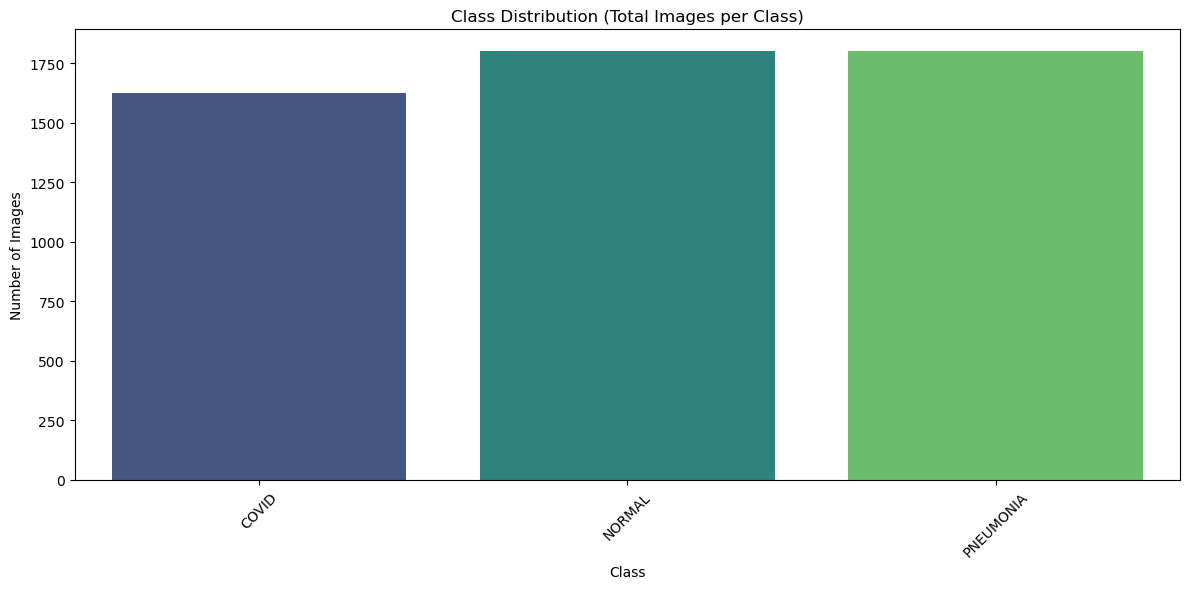

In [9]:
# Plot bar chart
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
plt.xticks(rotation=45)
plt.title('Class Distribution (Total Images per Class)')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

# PieChart

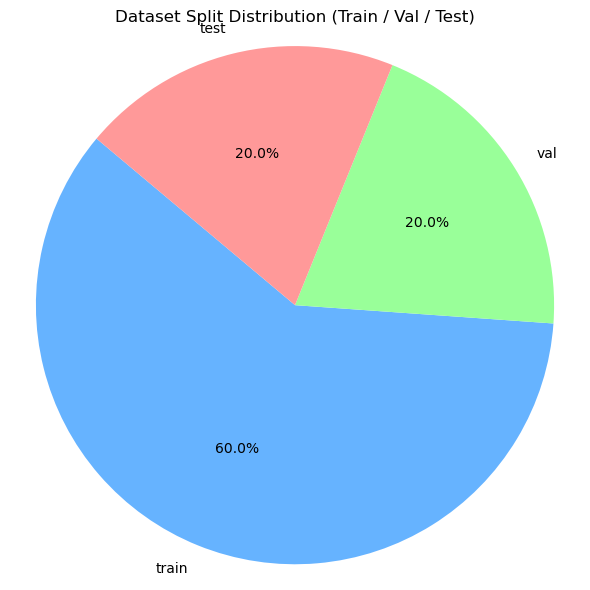

In [10]:
# Count total number of images in each split
split_counts = {}
for split in splits:
    split_path = os.path.join(base_dir, split)
    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        total += len(os.listdir(cls_path))
    split_counts[split] = total

# Plot pie chart for train/val/test distribution
plt.figure(figsize=(6, 6))
plt.pie(split_counts.values(), labels=split_counts.keys(), autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#99ff99', '#ff9999'])
plt.title('Dataset Split Distribution (Train / Val / Test)')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [11]:
img_size = 224
batch_size = 32

# Data Augmentation and Data Generators

In [12]:
# Data Augmentation and Generators

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(img_size, img_size),
    batch_size=batch_size, 
    class_mode='categorical'
)
val_gen = val_test_datagen.flow_from_directory(
    val_dir, 
    target_size=(img_size, img_size), 
    batch_size=batch_size, 
    class_mode='categorical'
)
test_gen = val_test_datagen.flow_from_directory(
    test_dir, 
    target_size=(img_size, img_size), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=False
)


Found 3136 images belonging to 3 classes.
Found 1045 images belonging to 3 classes.
Found 1047 images belonging to 3 classes.


# Build ResNet50 pretrained model

In [13]:
# Build ResNet50-based model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model

In [14]:
model.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy']
              )

# Add callbacks

In [15]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_accuracy'),
]

# Training

In [16]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

c:\Users\apeks\anaconda3\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 438s 4s/step - accuracy: 0.3392 - loss: 1.2979 - val_accuracy: 0.5560 - val_loss: 1.0409 - learning_rate: 0.0010
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 401s 4s/step - accuracy: 0.4090 - loss: 1.0769 - val_accuracy: 0.6900 - val_loss: 0.9873 - learning_rate: 0.0010
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 412s 4s/step - accuracy: 0.4462 - loss: 1.0398 - val_accuracy: 0.4833 - val_loss: 0.9621 - learning_rate: 0.0010
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 390s 4s/step - accuracy: 0.4788 - loss: 1.0096 - val_accuracy: 0.6335 - val_loss: 0.9381 - learning_rate: 0.0010
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 415s 4s/step - accuracy: 0.5235 - loss: 0.9853 - val_accuracy: 0.6555 - val_loss: 0.9155 - learning_rate: 0.0010
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 502s 5s/step - accuracy: 0.5606 - loss: 0.9496 - val_accuracy: 0.7703 - val_loss: 0.8989 - learning_rate: 1.0000e-04
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 554s 6s/step - accuracy: 0.5460 - loss: 0.9539 - val

# Save the model

In [22]:
import pickle
history_path ="C:\\Users\\apeks\\Downloads\\proje_his\\Resnet.pkl"
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)
# Save the model to an .keras file
model_path = "C:\\Users\\apeks\\Downloads\\proje_his\\Covid.keras"
model.save(model_path)

# Test

In [18]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.8331 - loss: 0.8826
Test Accuracy: 0.7593123316764832


# Classification Report

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predicted labels
test_gen.reset()
Y_true = test_gen.classes
Y_pred_probs = model.predict(test_gen, verbose=1)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Class labels
class_labels = list(test_gen.class_indices.keys())

33/33 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step


In [20]:
# Classification Report
print("Classification Report:\n")
print(classification_report(Y_true, Y_pred, target_names=class_labels))

Classification Report:

              precision    recall  f1-score   support

       COVID       0.82      0.83      0.82       326
      NORMAL       0.73      0.89      0.80       361
   PNEUMONIA       0.73      0.56      0.64       360

    accuracy                           0.76      1047
   macro avg       0.76      0.76      0.75      1047
weighted avg       0.76      0.76      0.75      1047



# Confusion Matrix

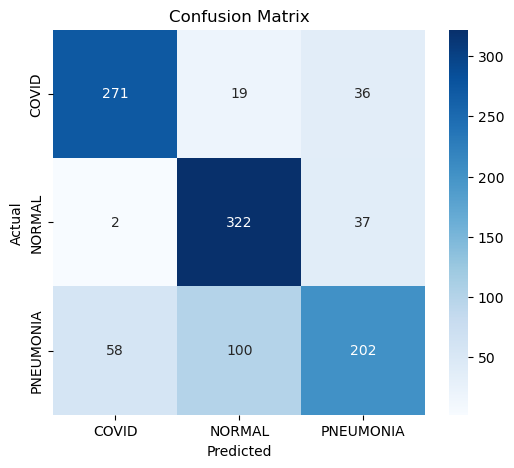

In [21]:
# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


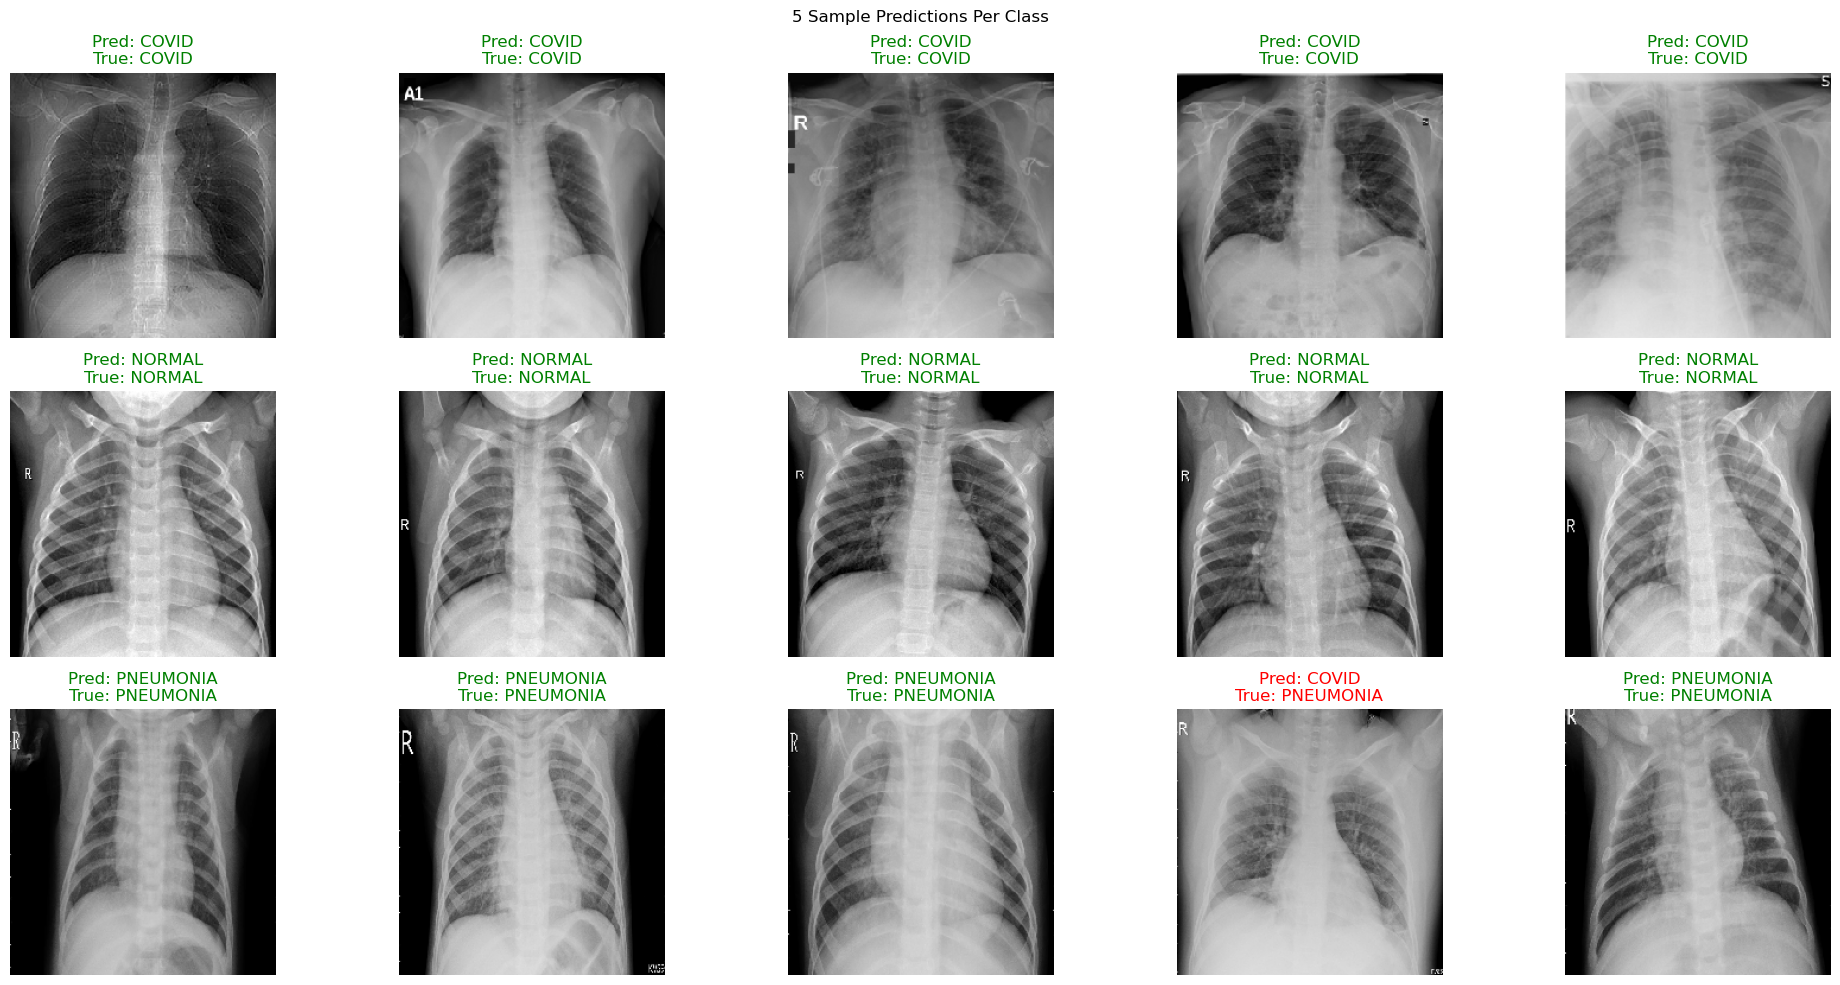

In [25]:
def get_n_samples_per_class(generator, model, samples_per_class=5):
    class_indices = generator.class_indices
    class_labels = list(class_indices.keys())
    n_classes = len(class_labels)

    samples = {cls_idx: [] for cls_idx in range(n_classes)}

    while any(len(v) < samples_per_class for v in samples.values()):
        images, true_labels = next(generator)
        pred_probs = model.predict(images)
        pred_labels = np.argmax(pred_probs, axis=1)
        true_labels_indices = np.argmax(true_labels, axis=1)

        for img, true_idx, pred_idx in zip(images, true_labels_indices, pred_labels):
            if len(samples[true_idx]) < samples_per_class:
                samples[true_idx].append((img, true_idx, pred_idx))

            if all(len(v) >= samples_per_class for v in samples.values()):
                break

    # Flatten samples dict to list
    selected_samples = []
    for cls_idx in range(n_classes):
        selected_samples.extend(samples[cls_idx])

    return selected_samples, class_labels

# Reset the generator before use
test_gen.reset()

samples, class_labels = get_n_samples_per_class(test_gen, model, samples_per_class=5)

# Plot 15 images (5 per class)
plt.figure(figsize=(20, 10))
for i, (img, true_idx, pred_idx) in enumerate(samples):
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_labels[pred_idx]}\nTrue: {class_labels[true_idx]}",
              color='green' if pred_idx == true_idx else 'red')

plt.suptitle("5 Sample Predictions Per Class")
plt.tight_layout()
plt.show()


# Load the model

In [1]:
from tensorflow.keras.models import load_model

# Load the model
model_path = "C:\\Users\\apeks\\OneDrive\\Desktop\\Covid19_dataset\\proje_his\\Covid.keras"
model = load_model(model_path)


# User Interface using Gradio

In [2]:
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# class labels
class_names = ['COVID', 'NORMAL', 'PNEUMONIA'] 

def predict_image(img):
    img = img.resize((224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    predictions = model.predict(img_array)[0]
    top_idx = np.argmax(predictions)
    
    return {class_names[i]: float(predictions[i]) for i in range(len(class_names))}

# Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="COVID/Normal/Pneumonia Detector (ResNet50)",
    description="Upload a chest X-ray image to classify."
)

interface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://0bafc0b9b963744eae.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
